## UNet Model

In [1]:
!pip install segmentation_models_pytorch_3d

In [2]:
import segmentation_models_pytorch_3d as smp
from segmentation_models_pytorch_3d.metrics import get_stats, iou_score

In [3]:
import os
import glob
import pathlib
from google.colab import drive
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.nn as nn
import numpy as np
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load & Augment Dataset

In [4]:
def load_data(data_dir):
  """ takes directory of data and returns the data in a numpy array """

  folder = pathlib.Path(data_dir)
  imgs = []

  for data in folder.iterdir():
    print(data)
    img = np.load(data)
    imgs.append(img)

  imgs = np.stack(imgs, axis = 0)
  return imgs



def load_batches(training_dir, masks_dir, batch_size):
  """args:
          training_dir (list)
          masks_dir (list)
          batch_size (int)
    returns:
          generator yields X, y (training portion) of a given batch_size for each iteration.
    it can be used as an alternative to pytorch's DataLoader()"""
  L = len(training_dir)
  i = 0
  while i < L:
    data = np.load(training_dir[i]).astype(np.float32)
    mask = np.load(masks_dir[i]).astype(np.float32)
    start = 0
    end = batch_size
    l = 0

    while l <= 11:

      yield data[start:end], mask[start:end]

      start+=batch_size
      end += batch_size
      l+=1
    i+=1


In [5]:
images_dir = "/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages"
masks_dir = "/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks"
images_dir2 = "/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages2"
masks_dir2 = "/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages2"
X = load_data(images_dir)

/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_1.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_2.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_3.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_4.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_6.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_7.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_8.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_9.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_10.npy


In [6]:
len(X)

344

In [7]:
X[0].shape

(128, 128, 128, 3)

In [8]:
y = load_data(masks_dir)

/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_1.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_2.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_3.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_4.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_6.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_7.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_8.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_9.npy
/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_10.npy
/content/drive/MyDrive/MRI_segmentation_UNet/

In [9]:
y[0].shape

(128, 128, 128, 4)

In [10]:
def plot_random(img: np.array, mask: np.array, channels = 3): # channels = 0, 1, 2
  """expectes stacked image with channels """
  rand_z = random.randint(0, img.shape[2] - 1)
  #rand_zm = random.randint(0, mask.shape[2]-1) #after preprocessing mask and image won't have the same number in dim Z
  titles = ["T1ce", "T2", "FLAIR"]
  print(f"Z dim: {rand_z}")
  fig, axs = plt.subplots(1, channels + 1, figsize = (10, 5)) # (channels + mask)

  for i in range(channels + 1):

    if i < channels:
        axs[i].imshow(img[:, :, rand_z, i])
        axs[i].axis('off')
        axs[i].set_title(f"channel {titles[i]}")

    if i >= channels:
      axs[i].imshow(mask[:, :, rand_z])
      axs[i].axis("off")
      axs[i].set_title("mask")

  plt.show()

## Visualize data

Z dim: 104


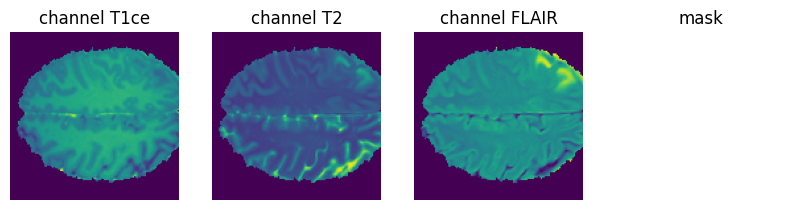

In [11]:
rand_idx = random.randint(0, len(X) - 1)
plot_random(X[rand_idx], y[rand_idx])

## Split training - validation

In [12]:
print(f"X: shape: {X.shape}")
print(f"y: shape: {y.shape}")

X: shape: (344, 128, 128, 128, 3)
y: shape: (344, 128, 128, 128, 4)


In [13]:
def train_val_test_split(X, y, train_size=0.9, val_size=0.1, plot=True):
  """ splits data into train, validation, and test sets """
  n_samples = X.shape[0]
  train_idx = int(n_samples * train_size)
  val_idx = int(n_samples * (train_size + val_size))

  train_x = X[0:train_idx, :, :, :, :]
  train_y = y[0:train_idx, :, :, :]

  val_x = X[train_idx:val_idx, :, :, :, :]
  val_y = y[train_idx:val_idx, :, :, :]

  test_x = X[val_idx:, :, :, :, :]
  test_y = y[val_idx:, :, :, :]

  print(f"Train shape: {train_x.shape}")
  print(f"Val shape: {val_x.shape}")
  print(f"Test shape: {test_x.shape}")

  if plot:
    sets = ['Training Set', 'Validation Set', 'Test Set']
    portions = [train_x.shape[0], val_x.shape[0], test_x.shape[0]]
    plt.bar(sets, portions)
    plt.title('Dataset distribution')
    plt.show()
  return train_x, train_y, val_x, val_y, test_x, test_y

Train shape: (309, 128, 128, 128, 3)
Val shape: (35, 128, 128, 128, 3)
Test shape: (0, 128, 128, 128, 3)


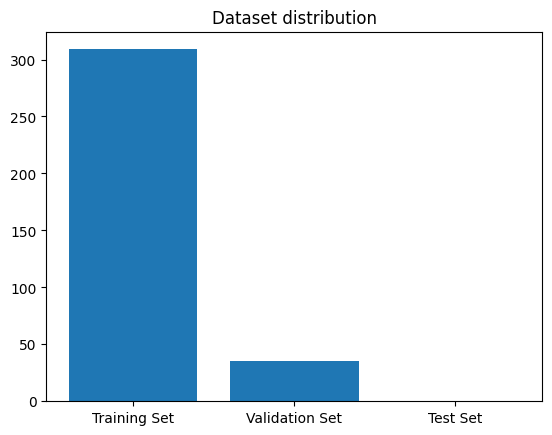

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)

In [15]:
y_train.shape, y_test.shape, y_val.shape

((309, 128, 128, 128, 4), (0, 128, 128, 128, 4), (35, 128, 128, 128, 4))

In [16]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_load = DataLoader(train_dataset, batch_size = 8, shuffle = True)

In [17]:
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
val_load = DataLoader(val_dataset, batch_size = 8, shuffle = True)

In [18]:
# test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
# test_load = DataLoader(test_dataset, batch_size = 8, shuffle = True)

## Augment Data

In [19]:
class AugmentTechniques():

  def __init__(self, channels, depth, height, width):
     self.channels, self.depth, self.height, self.width = channels, depth, height, width


  def flip(self, X, y, dimension):
    batch_size = X.shape[0]
    for batch in range(batch_size):
      img = X[batch, :, :, :, :]
      mask = y[batch, :, :, :]

      img = torch.flip(img, [dimension])
      mask = torch.flip(mask, [dimension - 1])
      X[batch, :, :, :, :] = img
      y[batch, :, :, :] = mask

    return X, y

  def gaussian_noise(self, X, sigma):
    batch_size = X.shape[0]
    for batch in range(batch_size):
      img = X[batch, :, :, :, :]
      # mask = y[batch, :, :, :]
      noise = torch.randn_like(img) * sigma
      img += noise
      X[batch, :, :, :, :] = img
      # y[batch, :, :, :] = mask

    return X

  def sharpen(self, X, y, sharpen_factor):
      batch_size = X.shape[0]
      for batch in range(batch_size):
          img = X[batch, :, :, :, :]
          mask = y[batch, :, :, :]

          for c in range(self.channels):
              for d in range(self.depth):
                  slice2d = img[c, d, :, :].unsqueeze(0)
                  sharpened_slice = TF.adjust_sharpness(slice2d, sharpen_factor)
                  img[c, d, :, :] = sharpened_slice.squeeze(0)

          for d in range(mask.shape[0]):
              slice2d = mask[d, :, :].unsqueeze(0)
              sharpened_slice = TF.adjust_sharpness(slice2d, sharpen_factor)
              mask[d, :, :] = sharpened_slice.squeeze(0)

          X[batch, :, :, :, :] = img
          y[batch, :, :, :] = mask

      return X, y

  def rotate(self, X, y, theta):
    batch_size = X.shape[0]
    for batch in range(batch_size):
        for d in range(self.depth):
            for c in range(self.channels):
                slice_2d = X[batch, c, d, :, :].unsqueeze(0)
                #slice_2d = X[batch, d, :, :, c].unsqueeze(0)
                rotated_slice = TF.rotate(slice_2d, theta)
                X[batch, c, d, :, :] = rotated_slice.squeeze(0)

            mask_slice = y[batch, d, :, :].unsqueeze(0)
            rotated_mask = TF.rotate(mask_slice, theta)
            y[batch, d, :, :] = rotated_mask.squeeze(0)

    return X, y

  def adjust_brightness(self, X, brightness_factor):
    batch_size = X.shape[0]
    for batch in range(batch_size):
      for c in range(self.channels):
        for d in range(self.depth):

          slice2d = X[batch, c, d, :, :].unsqueeze(0)
          adjusted_slice = TF.adjust_brightness(slice2d, brightness_factor)
          X[batch, c, d, :, :] = adjusted_slice.squeeze(0)

    return X

  def elastic_transform(self, X, y, alpha):
    batch_size = X.shape[0]
    for batch in range(batch_size):
      for c in range(self.channels):
        for d in range(self.depth):

          displacement_tensor = torch.randn(2, X.shape[3], X.shape[4]) * alpha / 100.0

          slice2d = X[batch, c, d, :, :].unsqueeze(0)
          mask = y[batch, d, :, :].unsqueeze(0)

          transformed_slice = TF.elastic_transform(slice2d, displacement_tensor)
          transformed_mask = TF.elastic_transform(mask, displacement_tensor)

          X[batch, c, d, :, :] = transformed_slice.squeeze(0)
          y[batch, d, :, :] = transformed_mask.squeeze(0)

    return X, y

  def translate(self, X, y, translate = (30, 40)):
    rand = random.uniform(-0.18, 0.18)
    rand_scale = random.uniform(0.9, 0.1)
    batch_size = X.shape[0]

    for batch in range(batch_size):
      for c in range(self.channels):
        for d in range(self.depth):
          slice2d = X[batch, c, d, :, :].unsqueeze(0)
          translated_slice = TF.affine(slice2d, angle = rand, translate = translate, scale = rand_scale, shear = rand)

          mask_slice = y[batch, d, :, :].unsqueeze(0)
          translated_mask = TF.affine(mask_slice, angle = rand, translate = translate, scale = rand_scale, shear = rand)

          X[batch, c, d, :, :] = translated_slice.squeeze(0)
          y[batch, d, :, :] = translated_mask.squeeze(0)

    return X, y

## Model Architecture

In [20]:
class DoubleConv(nn.Module):

  def __init__(self, in_channels, out_channels, num_groups = 8, dropout = 0.2):
    super().__init__()
    self.double_conv = nn.Sequential(

                                    nn.Conv3d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                    nn.GroupNorm(num_groups = num_groups, num_channels = out_channels),
                                    nn.LeakyReLU(inplace = True),
                                    nn.Dropout3d(dropout),

                                    nn.Conv3d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                    nn.GroupNorm(num_groups = num_groups, num_channels = out_channels),
                                    nn.LeakyReLU(inplace = True),
                                    nn.Dropout3d(dropout)

    )

  def forward(self, x):
    return self.double_conv(x)


class UpSample(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()

    #self.up = nn.ConvTranspose3d(in_channels //2 , in_channels // 2, kernel_size = 2, stride = 2)
    self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
    self.conv = DoubleConv(in_channels = in_channels, out_channels = out_channels, dropout = 0.2)
                 # 512, 256
  def forward(self, x1, x2):

    x1 = self.up(x1)
    if (x1.size() != x2.size()): # HERE I NEED TO PAD X1 TO MATCH X2

        depth = x2.size(2) - x1.size(2)
        height = x2.size(3) - x1.size(3)
        width = x2.size(4) - x1.size(4)

        x1 = F.pad(x1, (width // 2,
                        width - (width // 2),

                        height // 2,
                        height - (height // 2),

                        depth // 2,
                        depth - (depth // 2)))

    x = torch.cat([x2, x1], dim = 1)
    return self.conv(x)



class DownSample(nn.Module):

  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.down = nn.Sequential(
                            nn.MaxPool3d(kernel_size = 2, stride = 2),
                            DoubleConv(in_channels = in_channels, out_channels = out_channels, dropout = 0.15))

  def forward(self, x):
    return self.down(x)



class UNet3D(nn.Module):

  def __init__(self, in_channels, out_channels, init_channels = 32, num_groups = 8):
    super().__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.init_channels = init_channels
    self.num_groups = num_groups

    self.doubleconv1 = DoubleConv(in_channels, init_channels)

    #encoder
    self.encoder1 = DownSample(init_channels, init_channels * 2) # -> 32, 64
    self.encoder2 = DownSample(init_channels * 2, init_channels * 4) # -> 64, 128
    self.encoder3 = DownSample(init_channels * 4, init_channels * 8) # -> 128, 256
    self.encoder4 = DownSample(init_channels * 8, init_channels * 8) # -> 256, 256

    #decoder
    self.decoder1 = UpSample(init_channels * 16, init_channels * 4) # 512, 128
    self.decoder2 = UpSample(init_channels * 8, init_channels * 2) # 256, 64
    self.decoder3 = UpSample(init_channels * 4, init_channels) # 128, 32
    self.decoder4 = UpSample(init_channels * 2, init_channels) # 64, 32

    self.output = nn.Conv3d(init_channels, out_channels, kernel_size = 1)

  def forward(self, x):

    x1 = self.doubleconv1(x)
    x2 = self.encoder1(x1)
    x3 = self.encoder2(x2)
    x4 = self.encoder3(x3)
    x5 = self.encoder4(x4)
    # print("testing decoder 1")
    d1 = self.decoder1(x5, x4)
    # print("testing decoder 2")
    d2 = self.decoder2(d1, x3)
    # print("testing decoder 3")
    d3 = self.decoder3(d2, x2)
    # print("testing decoder 4")
    d4 = self.decoder4(d3, x1)

    out = self.output(d4)

    return out

## Class weight calculation

In [21]:
def avg(L):
  """returns average of a list"""
  return round(sum(L) / (len(L) + 0.0001), 2)

def class_distribution(training_dataset):
    """ takes: mask (tensor)
        returns: class distribution in a mask (y) for unequal representation in dice loss calculation"""
    w0_num = w0_den = w1_num = w1_den = w2_num = w2_den = w3_num = w3_den = 0
    for x, y in training_dataset:
      for mask in y:
        val, ct = np.unique(mask, return_counts=True)
        c = dict(zip(val, ct))

        total = sum(c.values())
        w0_num += total
        w0_den += c.get(0, 1)
        w1_num += total
        w1_den += c.get(1, 1)
        w2_num += total
        w2_den += c.get(2, 1)
        if 3 in c:
            w3_num += total
            w3_den += c.get(3, 1)

    num_classes = 4
    w0 = round(w0_num / (num_classes * w0_den), 2)
    w1 = round(w1_num / (num_classes * w1_den), 2)
    w2 = round(w2_num / (num_classes * w2_den), 2)

    if w3_den > 0:
        w3 = round(w3_num / (num_classes * w3_den), 2)
        weights = [w0, w1, w2, w3]
        weights = [round(w / sum(weights), 4) for w in weights]
        return weights
    else:
        weights = [w0, w1, w2]
        weights = [round(w / sum(weights), 3) for w in weights]
        return weights


def class_distribution2(training_dataset):
    """Calculate inverse weights for tumor classes only (1, 2, 3)"""
    class_counts = {1: 0, 2: 0, 3: 0}
    total_tumor_pixels = 0

    for x, y in training_dataset:
        for mask in y:
            val, ct = np.unique(mask, return_counts=True)
            for v, c in zip(val, ct):
                if int(v) in [1, 2, 3]:  # Only tumor classes
                    class_counts[int(v)] += c
                    total_tumor_pixels += c

    # Calculate inverse weights for tumor classes
    weights = []
    for i in [1, 2, 3]:
        if class_counts[i] > 0:
            weight = total_tumor_pixels / (3 * class_counts[i])  # Inverse frequency
        else:
            weight = 1.0
        weights.append(weight)

    # Normalize weights
    weight_sum = sum(weights)
    weights = [w / weight_sum for w in weights]

    return weights

## Loss Function

In [22]:
def dice_score(pred, target):
    classes = pred.shape[1]  # 0, 1, 2, 3
    batch_size = pred.shape[0]
    #target = F.one_hot(target, classes).permute(0, 4, 1, 2, 3).float()

    pred = F.softmax(pred, dim=1)
    preds = pred[:, 1:4, ...]  # [B, 3, D, H, W]

    #target = target.permute(0, 4, 1, 2, 3)
    targets = target[:, 1:4, ...]  # [B, 3, D, H, W]


    dice_losses = []
    dice_scores = []

    for b in range(batch_size):
        for c in range(classes-1):
            pred_c = preds[b, c, :, :, :]
            target_c = targets[b, c, :, :, :]

            if pred_c.sum() == 0 and target_c.sum() == 0:
                dice_score = 1.0
                # dice_loss = 0.0
            else:

                intersection = torch.sum(pred_c * target_c)
                union = torch.sum(pred_c) + torch.sum(target_c)
                dice_score = (2 * intersection + 1e-6) / (union + 1e-6)

                # weight = weights[c] if weights is not None else 1.0
                # dice_loss = weight * (1 - dice_score)

            dice_scores.append(dice_score)
            # dice_losses.append(dice_loss)

    # avg_loss = sum(dice_losses) / len(dice_losses)
    avg_score = sum(dice_scores) / len(dice_scores)

    return avg_score


def FL_DC(pred, target, diceLoss, focalLoss):

   if target.shape[1] == 4:
    #convert from one hot encoded to class indices -> 0, 1, 2, 3
    target = torch.argmax(target, dim = 1)

    dice_loss = diceLoss(pred, target)
    focal_loss = focalLoss(pred, target)
    return focal_loss + dice_loss

def Tversky_loss(pred, target, tverskyLoss):
  classes = pred.shape[1]
  return tverskyLoss(pred, target)

## Training


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 70
SEED = torch.manual_seed(42)
lr = 1e-4
model = UNet3D(3, 4, 24).cuda()
aug = AugmentTechniques(3, 128, 128, 128)
optimizer = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay = 1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.8, patience=8, min_lr=1e-7)
preds = []
train_losses = []
val_losses = []
ground_truth = []
dice_scores = []
iou_scores = []


#SMP Focal Loss:
train_weights = class_distribution2(train_load)
train_weights = torch.tensor(train_weights, device=device, dtype=torch.float32)
print(train_weights)
focalLoss = smp.losses.FocalLoss(mode = 'multiclass', alpha = 0.25, gamma = 4.0)
diceLoss = smp.losses.DiceLoss(mode = 'multiclass', classes = [1, 2, 3], log_loss = False, smooth = 1e-7,  from_logits = True)


tensor([0.1429, 0.4286, 0.4286], device='cuda:0')


In [24]:
for epoch in tqdm(range(NUM_EPOCHS)):

  train_loss = 0.0
  dice_train = 0.0
  val_loss = 0.0
  dice_val = 0.0
  iou_train = 0.0
  iou_val = 0.0
  for X_train, y_train in train_load:

    X_train = X_train.permute(0, 4, 1, 2, 3).contiguous()
    y_train = y_train.permute(0, 4, 1, 2, 3).contiguous()
    # augment data

    if (epoch >= 15 and epoch <= 25):
      sig = random.uniform(0.01, 0.02)
      X_train = aug.gaussian_noise(X_train, sigma = sig)

    if (epoch >= 26 and epoch <= 35):
      brightness_f = random.uniform(0.8, 1.2)
      X_train = aug.adjust_brightness(X_train, brightness_factor = brightness_f)

    # if ((epoch >= 36 and epoch <= 60)):
    #   dim = random.randint(1, 3)
    #   X_train, y_train = aug.flip(X_train, y_train, dimension = dim)

    # if ((epoch >= 33 and epoch <=43)):
    #   angle = random.uniform(0.3, 1.0)
    #   X_train, y_train = aug.rotate(X_train, y_train, theta = 0.05)

    # # if (epoch >= 0 and epoch <= 62):
    # #   X_train, y_train = aug.elastic_transform(X_train, y_train, alpha = 50.0)



    X_train = X_train.to(device)
    y_train = y_train.to(device)

    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)


    if (epoch == 54):
      preds.append(y_pred.detach().cpu())
      ground_truth.append(y_train.detach().cpu())
      # # CHECK CONFIDENCE
      # probs = F.softmax(y_pred, dim=1)
      # max_probs = probs.max(dim=1)[0]
      # print(f"confidence: {max_probs.mean():.3f}")


    # DICE SCORE + DICE LOSS
    dice = dice_score(y_pred, y_train.long())
    loss = FL_DC(y_pred, y_train.long(), diceLoss, focalLoss)

    #iou
    y_pred_classes = torch.argmax(y_pred, dim=1).contiguous()
    y_train_classes = torch.argmax(y_train, dim=1).contiguous()
    # print(f"y_pred_classes shape {y_pred_classes.shape}, y_pred shape {y_pred.shape}")
    tp, fp, fn, tn = get_stats(y_pred_classes, y_train_classes, mode='multiclass', num_classes = 4)
    iou = iou_score(tp, fp, fn, tn, reduction='macro')

    train_loss += loss
    dice_train += dice.detach().item()
    iou_train += iou.detach().item()


    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
    optimizer.step()

  train_loss /= len(train_load)
  dice_train /= len(train_load)
  iou_train /= len(train_load)

  if (epoch % 2 == 0):

    train_losses.append(train_loss)
    dice_scores.append(dice_train)
    iou_scores.append(iou_train)

  #validation part
  model.eval()
  with torch.no_grad():
    for X_val, y_val in val_load:
      X_val = X_val.permute(0, 4, 1, 2, 3)
      y_val = y_val.permute(0, 4, 1, 2, 3)
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      y_pred = model(X_val)

      # dice = FL_DC(y_pred, y_train.long(), train_weights, diceLoss, focalLoss) # using inverse weights here
      dice = dice_score(y_pred, y_val.long())
      loss = FL_DC(y_pred, y_val.long(), diceLoss, focalLoss)

      y_pred_classes = torch.argmax(y_pred, dim=1)
      y_val_classes = torch.argmax(y_val, dim=1)
      # print("x ,", X_val.shape,"Y, ", y_val.shape,"y_pred, ", y_pred.shape)
      tp, fp, fn, tn = get_stats(y_pred_classes, y_val_classes, mode='multiclass', num_classes = 4)
      iou = iou_score(tp, fp, fn, tn, reduction='macro')


      val_loss += loss.item()
      dice_val += dice.detach().item()
      iou_val += iou.detach().item()

      val_losses.append(val_loss)


      del X_val, y_val, y_pred, loss
      torch.cuda.empty_cache()
      gc.collect()

  val_loss /=len(val_load)
  dice_val /=len(val_load)
  iou_val /= len(val_load)

  scheduler.step(dice_val)

  if (epoch % 5 == 0 or epoch == NUM_EPOCHS - 1):
    curr_lr = optimizer.param_groups[0]['lr']
    print(f'EPOCH {epoch} | train loss: {train_loss} | dice (train) score: {dice_train} | iou (train): {iou_train}')
    print(f'val loss: {val_loss} | dice (validation) score: {dice_val} | iou (validation): {iou_val}')
    print(f'learning rate: {curr_lr}')




  0%|          | 0/70 [00:00<?, ?it/s]

EPOCH 0 | train loss: 1.0340925455093384 | dice (train) score: 0.030518946548302967 | iou (train): 0.21561853950604415
val loss: 0.9980904698371887 | dice (validation) score: 0.037269430980086324 | iou (validation): 0.3125240683555603
learning rate: 0.0001
EPOCH 5 | train loss: 0.9332533478736877 | dice (train) score: 0.09707276523113251 | iou (train): 0.41168613464404374
val loss: 0.8957783937454223 | dice (validation) score: 0.12737343162298204 | iou (validation): 0.44970724582672117
learning rate: 0.0001
EPOCH 10 | train loss: 0.8470317125320435 | dice (train) score: 0.17097482505517128 | iou (train): 0.4752864524340018
val loss: 0.7713928580284118 | dice (validation) score: 0.22453483939170837 | iou (validation): 0.5321585536003113
learning rate: 0.0001
EPOCH 15 | train loss: 0.7671284675598145 | dice (train) score: 0.23383931471751288 | iou (train): 0.4992108444372813
val loss: 0.6729365825653076 | dice (validation) score: 0.3129703998565674 | iou (validation): 0.5554159641265869


### Visualizing predictions

In [25]:
len(preds)

39

In [26]:
len(ground_truth)

39

In [27]:
print("Any NaNs in y_pred?", torch.isnan(preds[2]).any().item())
print("Any Infs in y_pred?", torch.isinf(preds[2]).any().item())
print("y_pred min/max/mean:", preds[1].min().item(), preds[2].max().item(), preds[2].mean().item())

Any NaNs in y_pred? False
Any Infs in y_pred? False
y_pred min/max/mean: -12.342109680175781 13.412114143371582 -1.2306634187698364


In [28]:
 # torch.Size([4, 4, 128, 128, 128])
print(ground_truth[0].shape, preds[0].shape)

torch.Size([8, 4, 128, 128, 128]) torch.Size([8, 4, 128, 128, 128])


In [29]:
prediction = F.softmax(preds[20], dim = 1)
gt = ground_truth[20].cpu().numpy()
prediction = prediction.argmax(dim = 1)
pred = prediction.cpu().numpy()
np.unique(pred), np.unique(gt)

(array([0, 1, 2, 3]), array([0., 1.], dtype=float32))

In [30]:
def plot_volumes(x, n):
  """args:
          x: tensor (prediction or truth)
          n: batch index
     returns:
          plot of all volumes in that batch"""
  fig, axs = plt.subplots(8, 16, figsize=(10, 6))
  for i in range(8):
   for j in range(16):
    axs[i][j].imshow(x[n, :, :, (i * j)])
    axs[i][j].set_axis_off()

plt.show()

def plot_rand_pred(pred, ground_truth, batch_no=3, channel=3):
    rand_z = random.randint(0, pred.shape[2] - 1)

    pred_slice = pred[:, :, :, rand_z]  # 4 x 128 x 128 x 128
    gt_slice = ground_truth[batch_no, :, :, :, rand_z]

    fig, axs = plt.subplots(2, 3, figsize=(10, 5))

    for i in range(channel):

        axs[0][i].imshow(pred_slice[i, :, :])
        axs[0][i].set_axis_off()
        axs[1][i].imshow(gt_slice[i, :, :])
        axs[1][i].set_axis_off()

    plt.show()

def plot_gt(x, n, slice_idx=64):
    """Plot all 4 channels for a specific slice"""
    if torch.is_tensor(x):
        x_np = x.cpu().numpy()
    else:
        x_np = x

    fig, axs = plt.subplots(1, 4, figsize=(10, 5))
    for channel in range(4):
        axs[channel].imshow(x_np[n, channel, :, :, slice_idx])
        axs[channel].set_title(f'Channel {channel}')
        axs[channel].set_axis_off()
    plt.show()

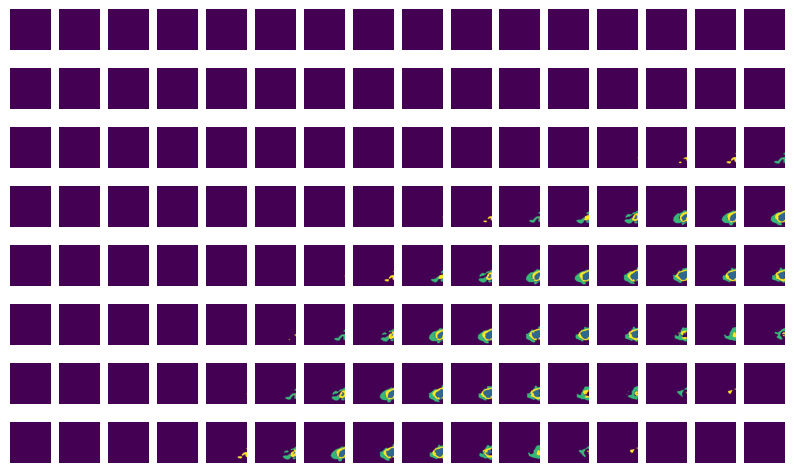

In [31]:
plot_volumes(pred, 1)

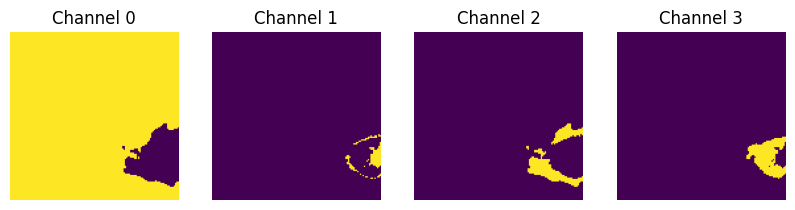

In [32]:
plot_gt(gt, 1) # ONE HOT ENCODED MASK

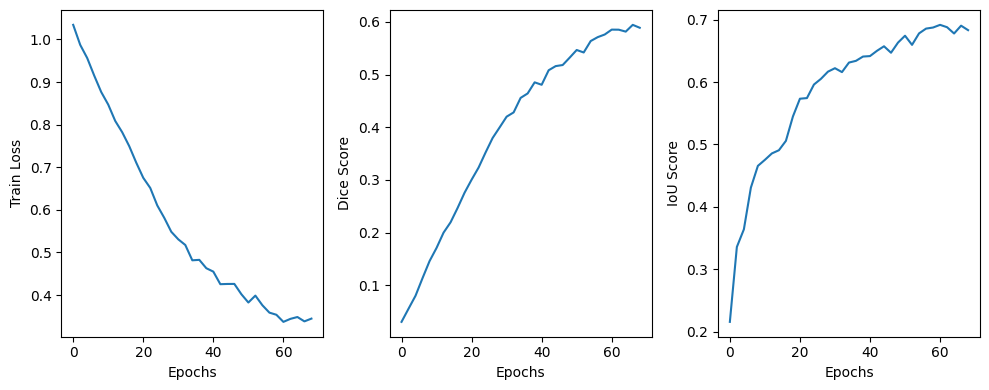

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
epoch_numbers = list(range(0, NUM_EPOCHS, 2))
train_losses = [tensor for tensor in train_losses]
dice_scores = [tensor for tensor in dice_scores]
iou_scores = [tensor for tensor in iou_scores]
axs[0].plot(epoch_numbers, train_losses)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Train Loss')

axs[1].plot(epoch_numbers, dice_scores)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Dice Score')

axs[2].plot(epoch_numbers, iou_scores)
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('IoU Score')
plt.tight_layout()
plt.show()
# plt.plot(train_losses, epoch_numbers)
# plt.xlabel('Train Loss')
# plt.ylabel('Epochs')
# # plt.show("Loss during training")
# plt.show()

## Saving model \& testing

In [37]:
weights_path = "/content/drive/MyDrive/MRI_segmentation_UNet/Best_Model_Weights"
model_path = "/content/drive/MyDrive/MRI_segmentation_UNet/Best_Model_Full"
# save with learnable params + training info
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

doubleconv1.double_conv.0.weight 	 torch.Size([24, 3, 3, 3, 3])
doubleconv1.double_conv.0.bias 	 torch.Size([24])
doubleconv1.double_conv.1.weight 	 torch.Size([24])
doubleconv1.double_conv.1.bias 	 torch.Size([24])
doubleconv1.double_conv.4.weight 	 torch.Size([24, 24, 3, 3, 3])
doubleconv1.double_conv.4.bias 	 torch.Size([24])
doubleconv1.double_conv.5.weight 	 torch.Size([24])
doubleconv1.double_conv.5.bias 	 torch.Size([24])
encoder1.down.1.double_conv.0.weight 	 torch.Size([48, 24, 3, 3, 3])
encoder1.down.1.double_conv.0.bias 	 torch.Size([48])
encoder1.down.1.double_conv.1.weight 	 torch.Size([48])
encoder1.down.1.double_conv.1.bias 	 torch.Size([48])
encoder1.down.1.double_conv.4.weight 	 torch.Size([48, 48, 3, 3, 3])
encoder1.down.1.double_conv.4.bias 	 torch.Size([48])
encoder1.down.1.double_conv.5.weight 	 torch.Size([48])
encoder1.down.1.double_conv.5.bias 	 torch.Size([48])
encoder2.down.1.double_conv.0.weight 	 torch.Size([96, 48, 3, 3, 3])
encoder2.down.1.double_conv.0.bi

In [38]:
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Streaming output truncated to the last 5000 lines.

          [[3.8400e-07, 3.4336e-07, 3.2813e-07],
           [3.8791e-07, 3.4467e-07, 3.2572e-07],
           [4.0749e-07, 3.6043e-07, 3.3697e-07]],

          [[3.8423e-07, 3.4460e-07, 3.2761e-07],
           [3.8807e-07, 3.4523e-07, 3.2447e-07],
           [4.0582e-07, 3.5934e-07, 3.3403e-07]]]],



        [[[[1.7739e-07, 1.8505e-07, 1.7648e-07],
           [1.8198e-07, 1.8974e-07, 1.8054e-07],
           [1.7420e-07, 1.8135e-07, 1.7218e-07]],

          [[1.8243e-07, 1.8999e-07, 1.8092e-07],
           [1.8747e-07, 1.9511e-07, 1.8537e-07],
           [1.7969e-07, 1.8670e-07, 1.7704e-07]],

          [[1.7305e-07, 1.7985e-07, 1.7113e-07],
           [1.7791e-07, 1.8474e-07, 1.7540e-07],
           [1.7074e-07, 1.7698e-07, 1.6772e-07]]],


         [[[2.3220e-08, 2.3813e-08, 2.3137e-08],
           [2.3804e-08, 2.4170e-08, 2.3204e-08],
           [2.2974e-08, 2.2960e-08, 2.1951e-08]],

          [[2.3274e-08, 2.3967e-08, 2.3377e-08],

In [39]:
torch.save(model.state_dict(), weights_path) # saving weights

torch.save(model, model_path + ".pth")

In [ ]:
# model.eval()
# with torch.no_grad():
#   for X_test, y_test in test_load:
#     dice_loss = 0
#     dice_score = 0
#     X_test = X_test.permute(0, 4, 1, 2, 3)
#     X_test = X_test.to(device)
#     y_test = y_test.to(device)
#     y_pred = model(X_test)
#     loss, dice = dice_score(y_pred, y_test.long())

#     del X_test, y_test, y_pred, loss
#     torch.cuda.empty_cache()
#     gc.collect()

#     dice_loss += loss.item()
#     dice_score += float(dice)

#   dice_loss /= len(test_load)
#   dice_score /= len(test_load)

#   print(f'test loss: {dice_loss} | dice (test) score: {dice_score}')

